In [ ]:
!pip install deap
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import array
import numpy as np
import random
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from IPython.display import display, clear_output

from google.colab import drive, output
drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/Labs mag/'
output.clear()

# Выбор параметров для алгоритма:


In [ ]:
# Genetic Algorithm constants:
POPULATION_SIZE = 700
P_CROSSOVER = 0.8  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 250 # length of bit string to be optimized

# problem constants:
HALL_OF_FAME_SIZE = 30

# Early stopping
USE_DELTA = True
MAX_DELTA =1  # max result delta 
MEAN_DELTA = 1  # mean result delta 
N_DELTA_GENERATIONS = 10  # number of generations < MAX_DELTA to stop

In [ ]:
best_route = []
with open(drive_data_path+"eil76.opt.tour.txt", "r") as f:
  for line in f:
    lines = line.split()
    if lines[0].isnumeric():
      best_route.append(int(lines[0])-1)

locations = {}
with open(drive_data_path+"eil76.txt", "r") as f:
  for line in f:
    lines = line.split()
    if lines[0].isnumeric():
      locations[int(lines[0])-1] = [int(lines[1]), int(lines[2])]

distances = {}
for i in range(len(locations)):
  for j in range(i, len(locations)):
    distance = np.sqrt((locations[j][0] - locations[i][0])**2 + (locations[j][1] - locations[i][1])**2)
    distances[i, j] = distance
    distances[j, i] = distance

def getTotalDistance(individual):
  sum = 0
  sum += distances[individual[0], individual[-1]]
  for i in range(len(individual)-1):
    sum += distances[individual[i], individual[i+1]]
  return sum

# Определение используемых функций:



In [ ]:
def CX(parent1, parent2):    
    p1 = list(parent1)
    p2 = list(parent2)   
    chrom_length = len(p1)
    c1 = [None]*chrom_length
    c2 = [None]*chrom_length

    swap = False
    count = 0
    pos = 0   

    while True:
        if (None not in c1) and (None not in c2) : break
        for i in range(chrom_length):
            if c1[i]==None:
                pos=i
                break

        if swap==True:
            while True:
                c1[pos] = p2[pos]
                c2[pos] = p1[pos]
                pos = p1.index(p2[pos])
                if c1[pos] != None:
                    swap = False
                    break
        elif swap==False:
            while True:
                c1[pos] = p1[pos]
                c2[pos] = p2[pos]
                pos = p1.index(p2[pos])
                if c1[pos] != None:
                    swap = True
                    break    
    c1_ind = toolbox.clone(parent1)      
    c2_ind = toolbox.clone(parent1) 
    for i in range(chrom_length):
      c1_ind[i] = c1[i]                 
      c2_ind[i] = c2[i]                       
    return c1_ind, c2_ind

In [ ]:
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list of integers:
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices:
toolbox.register("randomOrder", random.sample, range(len(locations)), len(locations))

# create the individual creation operator to fill up an Individual instance with shuffled indices:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)

# create the population creation operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation - compute the total distance of the list of cities represented by indices:
def tpsDistance(individual):
    return getTotalDistance(individual),  # return a tuple

toolbox.register("evaluate", tpsDistance)

# Genetic operators:
toolbox.register("selectTournament", tools.selTournament, tournsize=2)
toolbox.register("selectBest", tools.selBest)
toolbox.register("selectRandom", tools.selRandom)

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=6.0/len(locations))

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


# Цикл алгоритма:


 

In [ ]:
# Genetic Algorithm flow:

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)
generationCounter = 0

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# calculate fitness tuple for each individual in the population:
fitnessValues = list(map(toolbox.evaluate, population))
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue
hof.update(population)

# initialize statistics accumulators:
bestIndividuals = []
minFitnessValues = []
meanFitnessValues = []

all_Individuals = []
all_FitnessValues = []


# main evolutionary loop:
# stop if max fitness value reached the known max value
# OR if number of generations exceeded the preset value:
stop_delta_flag = False
delta_generations = 0
while generationCounter < MAX_GENERATIONS:
    # update counter:
    generationCounter = generationCounter + 1

    # apply the selection operator, to select the next generation's individuals:
    offspring = toolbox.selectTournament(population, POPULATION_SIZE - HALL_OF_FAME_SIZE)
    # clone the selected individuals:
    offspring = list(map(toolbox.clone, offspring))
    random.shuffle(offspring)

    # apply the crossover operator to pairs of offspring:
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            child1, child2 = CX(child1, child2)
            # toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values


    # calculate fitness for the individuals with no previous calculated fitness value:
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
        individual.fitness.values = fitnessValue

    # replace the current population with the offspring:
    # offspring.extend(hof.items)
    # population[:] = offspring
    population_offspring = population + offspring
    population[:] = toolbox.selectBest(population_offspring, round(POPULATION_SIZE*0.1)) \
     + toolbox.selectTournament(population_offspring, round(POPULATION_SIZE*0.5)) \
     + toolbox.selectRandom(population_offspring, round(POPULATION_SIZE*0.4))

    # collect fitnessValues into a list, update statistics and print:
    individuals = list(population)
    all_Individuals += [individuals]
    fitnessValues = [ind.fitness.values[0] for ind in population]
    all_FitnessValues += [fitnessValues]

    minFitness = min(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    minFitnessValues.append(minFitness)
    meanFitnessValues.append(meanFitness)
    # print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, minFitness, meanFitness))

    # find and print best individual:
    best_individual_index = fitnessValues.index(min(fitnessValues))
    best_individual = individuals[best_individual_index]
    bestIndividuals.append(best_individual)
    # print("Best Individual = ", individuals[best_individual_index])
    # print("Unique individuals = ", len(set(individuals)), "\n")

    hof.update(population)

    if USE_DELTA:
        if generationCounter > N_DELTA_GENERATIONS:
          if abs(minFitnessValues[-2] - minFitnessValues[-1]) < MAX_DELTA and \
          abs(meanFitnessValues[-2] - meanFitnessValues[-1]) < MEAN_DELTA:
            delta_generations += 1
          else:
            delta_generations = 0
          if delta_generations == N_DELTA_GENERATIONS:
            stop_delta_flag = True
            print('Early stopping: ', generationCounter)



Сравнение с лучшим значением на протяжении всей эволюции

In [ ]:
print("True distance = ", round(getTotalDistance(best_route), 5))

print("Min Fitness =", round(hof.items[0].fitness.values[0], 5)) 
print("Best x = ", hof.items[0])

True distance =  545.38755
Min Fitness = 1347.76779
Best x =  Individual('i', [67, 31, 24, 10, 64, 37, 28, 35, 36, 59, 32, 55, 62, 47, 27, 63, 60, 20, 68, 19, 14, 44, 72, 22, 30, 65, 75, 34, 52, 58, 13, 33, 7, 74, 16, 43, 66, 51, 26, 12, 53, 69, 70, 56, 18, 3, 45, 25, 29, 11, 57, 8, 71, 38, 15, 2, 49, 9, 50, 48, 41, 23, 17, 54, 39, 5, 61, 21, 40, 42, 0, 6, 73, 4, 46, 1])


# Графики

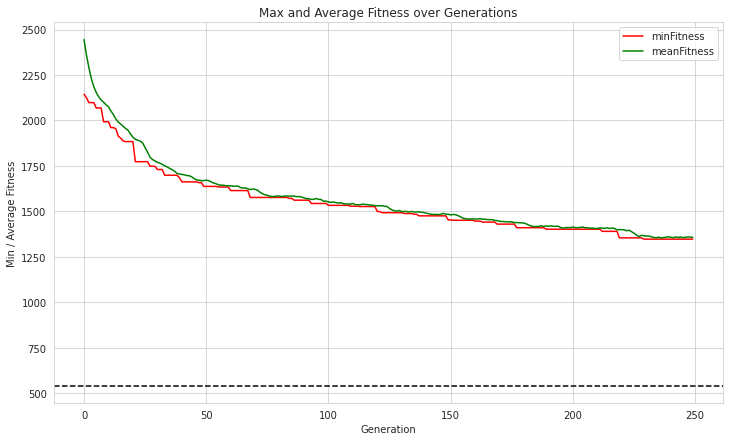

In [ ]:
# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(minFitnessValues, color='red', label='minFitness')
plt.plot(meanFitnessValues, color='green', label='meanFitness')
plt.axhline(y=543.2485989128454, color='k', linestyle='--')
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

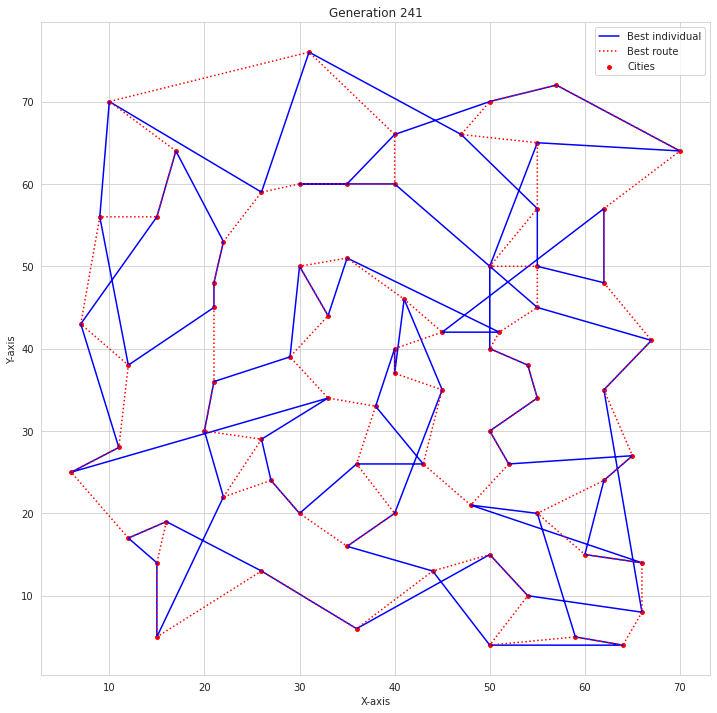

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
best_locs = best_route + [best_route[0]]
best_locs = [locations[i] for i in best_locs]
for i in range(0, generationCounter, 10):
    ax.cla()
    ax.scatter(*zip(*locations.values()), marker='o', color='red', s=15, label='Cities')
    locs = [locations[i] for i in bestIndividuals[i]]
    locs.append(locs[0])
    ax.plot(*zip(*locs), linestyle='-', color='blue', label='Best individual')
    ax.plot(*zip(*best_locs), linestyle=':', color='red', label='Best route')

    # setting labels
    plt.legend()
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Generation "+str(i+1))

    display(fig)    
    time.sleep(0.8)
    clear_output(wait = True)